In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import entropy
import math
from sklearn import metrics

In [70]:
data_excel = pd.read_csv("data/Base14.csv")
dataframe_data = pd.DataFrame(data_excel)
dataframe_train = pd.DataFrame(dataframe_data.drop(columns=['label']))
# print(dataframe_data)
# print(dataframe_train)

Text(0, 0.5, 'Y')

<Figure size 800x500 with 0 Axes>

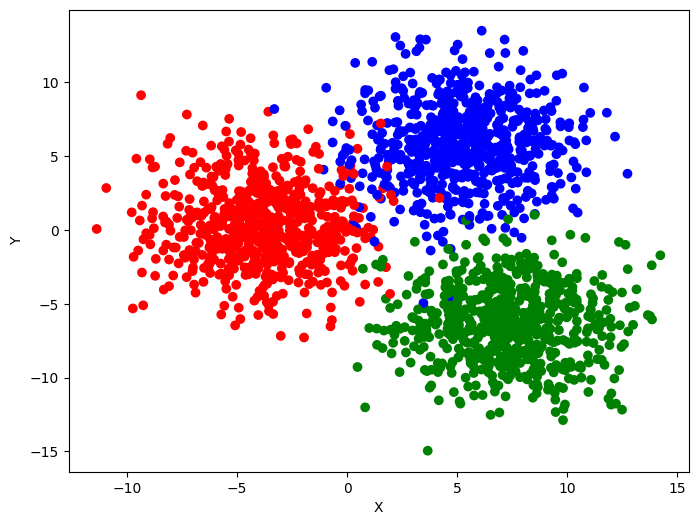

In [71]:
plt.figure(figsize=(8,5))
label_colors = {0: 'red', 1: 'blue', 2: 'green'}

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(dataframe_train['x'], dataframe_train['y'], c=dataframe_data['label'].apply(lambda x: label_colors[x]))

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()

# KMeans

## Impl

In [72]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import euclidean_distances

# Defining the parameter grid for KMeans
param_grid = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Varying the number of clusters
    "max_iter": [100, 200, 300, 400, 500],  # Varying the maximum number of iterations
}


# Modify the plotting function to save plots
def plot_clustering(kmeans_model, dataframe_train, dataframe_data, params):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(30, 10))
    centro = kmeans_model.cluster_centers_

    # Plot for KMeans
    ax1.set_title(f"KMeans: {params}")
    ax1.scatter(dataframe_train["x"], dataframe_train["y"], c=kmeans_model.labels_)
    ax1.scatter(centro[:, 0], centro[:, 1], color="red")

    # Plot for Original
    ax2.set_title("Original")
    ax2.scatter(
        dataframe_train["x"],
        dataframe_train["y"],
        c=dataframe_data["label"].apply(lambda x: label_colors[x]),
    )

    # Save the plot
    plt.savefig(
        f"kmeans_output/iters_{params['max_iter']}_clusters_{params['n_clusters']}.png"
    )
    plt.close(f)  # Close the figure to avoid displaying it in the notebook

def compute_separation(kmeans_model, data):
    """Computes the separation of a KMeans clustering model."""
    overall_mean = np.mean(data, axis=0)
    separation = 0
    for center, label in zip(kmeans_model.cluster_centers_, range(kmeans_model.n_clusters)):
        cluster_size = len(data[kmeans_model.labels_ == label])
        separation += cluster_size * np.sum((center - overall_mean) ** 2)
    return separation

def calculate_metrics(kmeans_model, dataframe_data):
    silhouette = metrics.silhouette_score(dataframe_train, kmeans_model.labels_)
    homogeneity = metrics.homogeneity_score(
        dataframe_data["label"], kmeans_model.labels_
    )
    completeness = metrics.completeness_score(
        dataframe_data["label"], kmeans_model.labels_
    )
    rand_index = metrics.rand_score(
        dataframe_data["label"], kmeans_model.labels_
    )
    entropy_value = entropy(np.bincount(kmeans_model.labels_))

    cohesion = math.sqrt(kmeans.inertia_) / kmeans.n_clusters
    separation = compute_separation(kmeans_model, dataframe_train)
    ssd = kmeans.inertia_

    return (
        ssd,
        silhouette,
        homogeneity,
        completeness,
        rand_index,
        entropy_value,
        cohesion,
        separation,
    )

kmeans_results = []

# Iterate over the parameter grid and plot
parameter_grid = ParameterGrid(param_grid)

for params in parameter_grid:
    kmeans = KMeans(**params, random_state=0, n_init=10)
    kmeans.fit(dataframe_train)

    plot_clustering(kmeans, dataframe_train, dataframe_data, params)
    computed_metrics = calculate_metrics(kmeans, dataframe_data)

    kmeans_results.append({
        "params": params,
        "ssd": computed_metrics[0],
        "silhouette": computed_metrics[1],
        "homogeneity": computed_metrics[2],
        "completeness": computed_metrics[3],
        "rand_index": computed_metrics[4],
        "entropy": computed_metrics[5],
        "cohesion": computed_metrics[6],
        "separation": computed_metrics[7],
    })

# convert results array into a dataframe
kmeans_results_df = pd.DataFrame(kmeans_results)

# generate csv file
kmeans_results_df.to_csv("kmeans_output/kmeans_results.csv", index=False)

# print(
#     "\nSoma dos quadrados das distâncias até o centróide mais próximo: ",
#     kmeans.inertia_,
# )
# print("\nCoesão: ", math.sqrt(kmeans.inertia_) / kmeans.n_clusters)
# print(
#     "\nCoeficiente de Silhueta: ",
#     metrics.silhouette_score(dataframe_train, kmeans.labels_),
# )
# print(
#     "\nRand Score K-means: ",
#     metrics.rand_score(dataframe_data["label"], kmeans.labels_),
# )
# print(
#     "\nHomogeneidade : ",
#     metrics.homogeneity_score(dataframe_data["label"], kmeans.labels_),
# )
# print(
#     "\nCompletude : ",
#     metrics.completeness_score(dataframe_data["label"], kmeans.labels_),
# )
# print(
#     "\nMatriz de contingência kmeans\n",
#     contingency_matrix(dataframe_data["label"], kmeans.labels_),
# )

## Analysis

In [73]:
# Load the results DataFrame
kmeans_results_df = pd.read_csv("kmeans_output/kmeans_results.csv")

# Function to rank configurations based on a combination of metrics
def rank_configurations(df):
    # Define your ranking logic here
    # For example, you might want to prioritize silhouette and homogeneity
    df['overall_score'] = df['silhouette'] + df['homogeneity']  # This is just an example
    return df

# Rank the configurations
ranked_df = rank_configurations(kmeans_results_df)

# Find the best configuration
best_config = ranked_df.sort_values(by='overall_score', ascending=False).iloc[0]
print("Best KMeans Configuration:")
print(best_config)

Best KMeans Configuration:
params           {'max_iter': 300, 'n_clusters': 3}
ssd                                    25764.054617
silhouette                                  0.58363
homogeneity                                0.906223
completeness                               0.906236
rand_index                                 0.975086
entropy                                    1.098597
cohesion                                  53.503951
separation                             96852.104842
overall_score                              1.489853
Name: 19, dtype: object


# DBSCAN

## Impl

In [74]:
# Define the parameter grid for DBSCAN
param_grid = {
    "eps": [0.3, 0.5, 0.7, 1.0, 1.2, 1.5, 1.7],  # Varying the eps
    "min_samples": [5, 10, 12, 15, 20],  # Varying the minimum number of samples
}


# Function to plot the clustering results
def plot_dbscan_clustering(dbscan_model, dataframe_train, dataframe_data, params):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(30, 10))
    # centro = dbscan_model.cluster_centers_

    # Plot for KMeans
    ax1.set_title(f"KMeans: {params}")
    ax1.scatter(dataframe_train["x"], dataframe_train["y"], c=dbscan_model.labels_)
    # ax1.scatter(centro[:, 0], centro[:, 1], color="red")

    # Plot for Original
    ax2.set_title("Original")
    ax2.scatter(
        dataframe_train["x"],
        dataframe_train["y"],
        c=dataframe_data["label"].apply(lambda x: label_colors[x]),
    )

    # Save the plot
    plt.savefig(
        f"dbscan_output/eps_{params['eps']}_min_samples_{params['min_samples']}.png"
    )
    plt.close(f)  # Close the figure to avoid displaying it in the notebook


# Function to compute metrics for DBSCAN (similar to KMeans)
def calculate_dbscan_metrics(dbscan_model, dataframe_data):
    labels = dbscan_model.labels_
    non_noise_labels = labels[labels != -1]

    # Check if there are at least 2 non-noise clusters to calculate silhouette score
    if len(set(non_noise_labels)) >= 2:
        silhouette = metrics.silhouette_score(dataframe_train[labels != -1], non_noise_labels)
    else:
        silhouette = None  # Silhouette score is not meaningful in this case

    # Other metrics can be calculated normally
    homogeneity = metrics.homogeneity_score(dataframe_data["label"], labels)
    completeness = metrics.completeness_score(dataframe_data["label"], labels)
    rand_index = metrics.adjusted_rand_score(dataframe_data["label"], labels)
    entropy_value = entropy(np.bincount(non_noise_labels)) if len(non_noise_labels) > 0 else None

    # return a dictionary with the metrics
    return {
        "silhouette": silhouette,
        "rand_index": rand_index,
        "homogeneity": homogeneity,
        "completeness": completeness,
        "entropy": entropy_value,
    }


dbscan_results = []

# Iterate over the parameter grid
parameter_grid = ParameterGrid(param_grid)
for params in parameter_grid:
    dbscan = DBSCAN(**params)
    dbscan.fit(dataframe_train)

    plot_dbscan_clustering(dbscan, dataframe_train, dataframe_data, params)
    computed_metrics = calculate_dbscan_metrics(dbscan, dataframe_data)

    dbscan_results.append(
        {
            "params": params,
            **computed_metrics
        }
    )

# Convert results array into a DataFrame
dbscan_results_df = pd.DataFrame(dbscan_results)

# Optionally, save to a CSV file
dbscan_results_df.to_csv("dbscan_output/dbscan_results.csv", index=False)

## Analysis

In [75]:
# Load the DBSCAN results DataFrame
dbscan_results_df = pd.read_csv("dbscan_output/dbscan_results.csv")

valid_results_df = dbscan_results_df.dropna(subset=['silhouette', 'entropy'])

if valid_results_df.empty:
    raise ValueError("All DBSCAN configurations resulted in invalid clustering. Consider adjusting the parameters.")

# Define a scoring function
def score_row(row):
    return row['silhouette'] + row['homogeneity'] + row['completeness'] + row['rand_index'] - row['entropy']

# Apply the scoring function
valid_results_df['score'] = valid_results_df.apply(score_row, axis=1)

# Find the best configuration
best_config = valid_results_df.sort_values(by='score', ascending=False).iloc[0]
print("Best DBSCAN Configuration:")
print(best_config)

Best DBSCAN Configuration:
params          {'eps': 1.0, 'min_samples': 15}
silhouette                             0.637546
rand_index                             0.749019
homogeneity                            0.808396
completeness                           0.658177
entropy                                1.098546
score                                  1.754591
Name: 18, dtype: object


/tmp/ipykernel_15704/1193489992.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_results_df['score'] = valid_results_df.apply(score_row, axis=1)


# Agglomerative

## Impl

In [76]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import ParameterGrid

# Define the parameter grid for AgglomerativeClustering
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Varying the number of clusters
    'linkage': ['ward', 'complete', 'average', 'single']  # Varying the linkage criterion
}

# Function to plot the clustering results (Similar to previous implementations)
def plot_agglomerative_clustering(agglom_model, dataframe_train, dataframe_data, params):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(30, 10))

    # Plot for KMeans
    ax1.set_title(f"KMeans: {params}")
    ax1.scatter(dataframe_train["x"], dataframe_train["y"], c=agglom_model.labels_)

    # Plot for Original
    ax2.set_title("Original")
    ax2.scatter(
        dataframe_train["x"],
        dataframe_train["y"],
        c=dataframe_data["label"].apply(lambda x: label_colors[x]),
    )

    # Save the plot
    plt.savefig(
        f"agglomerative_output/n_clusters_{params['n_clusters']}_linkage_{params['linkage']}.png"
    )
    plt.close(f)  # Close the figure to avoid displaying it in the notebook


# Function to compute metrics for AgglomerativeClustering (Similar to previous implementations)
def calculate_agglomerative_metrics(agglom_model, dataframe_data):
    labels = agglom_model.labels_

    # Silhouette score
    silhouette = metrics.silhouette_score(dataframe_train, labels)

    # The following metrics require ground truth labels
    # If you don't have ground truth labels, you can skip these
    homogeneity = metrics.homogeneity_score(dataframe_data["label"], labels)
    completeness = metrics.completeness_score(dataframe_data["label"], labels)
    rand_index = metrics.adjusted_rand_score(dataframe_data["label"], labels)

    # Davies-Bouldin and Calinski-Harabasz Index
    davies_bouldin = metrics.davies_bouldin_score(dataframe_train, labels)
    calinski_harabasz = metrics.calinski_harabasz_score(dataframe_train, labels)

    return {
        "silhouette": silhouette,
        "homogeneity": homogeneity,
        "completeness": completeness,
        "rand_index": rand_index,
        "davies_bouldin": davies_bouldin,
        "calinski_harabasz": calinski_harabasz
    }

agglomerative_results = []

# Iterate over the parameter grid
parameter_grid = ParameterGrid(param_grid)
for params in parameter_grid:
    agglom = AgglomerativeClustering(**params)
    agglom.fit(dataframe_train)

    plot_agglomerative_clustering(agglom, dataframe_train, dataframe_data, params)
    computed_metrics = calculate_agglomerative_metrics(agglom, dataframe_data)

    agglomerative_results.append({
        'params': params,
        **computed_metrics
    })

# Convert results array into a DataFrame
agglomerative_results_df = pd.DataFrame(agglomerative_results)

# Optionally, save to a CSV file
agglomerative_results_df.to_csv("agglomerative_output/agglomerative_results.csv", index=False)


## Analysis

In [77]:
# Load the Agglomerative Clustering results DataFrame
agglomerative_results_df = pd.read_csv("agglomerative_output/agglomerative_results.csv")

def score_row(row):
    return row['silhouette'] + row['homogeneity'] + row['completeness'] + row['rand_index'] + row['calinski_harabasz'] - row['davies_bouldin']

# Apply the scoring function
agglomerative_results_df['score'] = agglomerative_results_df.apply(score_row, axis=1)

# Find the best configuration
best_config = agglomerative_results_df.sort_values(by='score', ascending=False).iloc[0]
print("Best Agglomerative Clustering Configuration:")
print(best_config)

Best Agglomerative Clustering Configuration:
params               {'linkage': 'ward', 'n_clusters': 3}
silhouette                                       0.578436
homogeneity                                      0.881256
completeness                                     0.881333
rand_index                                       0.925007
davies_bouldin                                   0.582108
calinski_harabasz                             3685.686884
score                                         3688.370807
Name: 1, dtype: object
